# Trip Duration Prediction

This project aims to predict the duration of taxi trips in New York City.  
We analyze the dataset `trip_data.csv` to understand patterns and relationships between features like pickup/dropoff locations, time, and passenger count.

EDA (Exploratory Data Analysis) is performed to:
- Detect missing values and data types.
- Understand feature distributions.
- Identify correlations and outliers.
- Prepare the dataset for feature engineering and modeling.




# imort all liberaries we need

In [1]:
import sys
import os

# Add the 'src' folder to Python path
sys.path.append(os.path.abspath(os.path.join("..", "src")))

# Now you can import custom modules
from features.distances import add_distance_features
from features.timeparts import add_time_features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Quick Initial Look
Initial Load & Overview


In [2]:
# Load raw training data
df = pd.read_csv(r"G:\ML mostafa saad\slides\my work\13 Project 1 - Regression - Trip Duration Prediction\data\raw\train.csv")

# Check shape, first rows, and basic info
print(df.shape)
print(df.head())
print(df.info())


(1000000, 10)
          id  vendor_id      pickup_datetime  passenger_count  \
0  id2793718          2  2016-06-08 07:36:19                1   
1  id3485529          2  2016-04-03 12:58:11                1   
2  id1816614          2  2016-06-05 02:49:13                5   
3  id1050851          2  2016-05-05 17:18:27                2   
4  id0140657          1  2016-05-12 17:43:38                4   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.985611        40.735943         -73.980331         40.760468   
1        -73.978394        40.764351         -73.991623         40.749859   
2        -73.989059        40.744389         -73.973381         40.748692   
3        -73.990326        40.731136         -73.991264         40.748917   
4        -73.789497        40.646675         -73.987137         40.759232   

  store_and_fwd_flag  trip_duration  
0                  N           1040  
1                  N            827  
2                 

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Column Analysis & Potential Issues

I want to understand each column a bit, identify any potential issues, and figure out how to handle them.


###  Missing Values Check
Identify any columns with missing values.

Goal: Decide whether to impute the missing values or drop them.

In [ ]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Target Variable Analysis

First, convert the target to minutes for easier understanding.

- `trip_duration` → plot histogram / KDE
- Calculate skewness and check for outliers
- Consider whether a log-transform is needed

**Goal:** Understand the distribution of the target before any modeling.


   trip_duration  trip_duration_min
0           1040          17.333333
1            827          13.783333
2            614          10.233333
3            867          14.450000
4           4967          82.783333


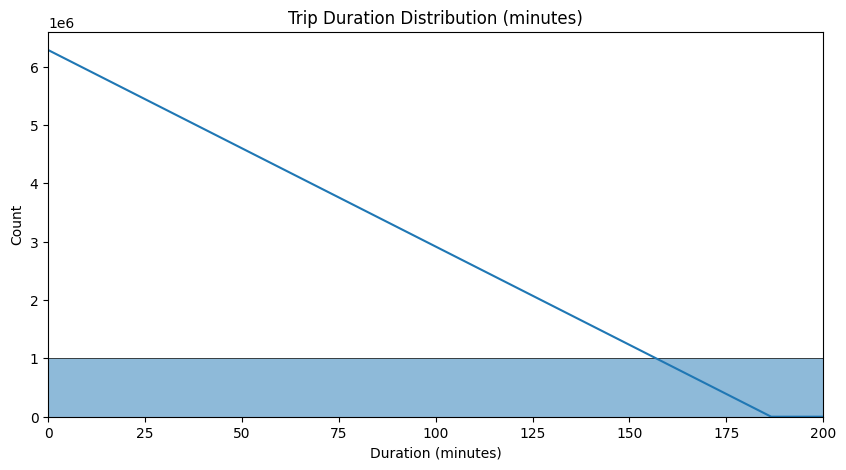

Skewness of trip_duration (minutes): 202.56
Trips with duration < 1 min: 5809
Trips with duration > 120 min: 1548


In [ ]:


# Convert from seconds to minutes
df['trip_duration_min'] = df['trip_duration'] / 60

# Quick view of the conversion
print(df[['trip_duration', 'trip_duration_min']].head())

# Plot distribution
plt.figure(figsize=(10,5))
sns.histplot(df['trip_duration_min'], bins=100, kde=True)
plt.xlim(0, 200)  # assume most trips are under 200 minutes
plt.title("Trip Duration Distribution (minutes)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Count")
plt.show()

# Calculate skewness
skewness = df['trip_duration_min'].skew()
print(f"Skewness of trip_duration (minutes): {skewness:.2f}")

# Detect very short or very long trips
print("Trips with duration < 1 min:", (df['trip_duration_min'] < 1).sum())
print("Trips with duration > 120 min:", (df['trip_duration_min'] > 120).sum())



# The distribution is highly skewed to the right:

- Most trips are short (less than ~1000 seconds).
- A few trips are extremely long, creating outliers.
- There are many trips under 1 minute and very few over 2 hours.

**Next Step:** We need to Apply a log-transform to the target variable to reduce skewness.


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Categorical Columns Analysis  

- **Columns:** `vendor_id`, `store_and_fwd_flag`  
- **Goal:** Check the distribution of each category and decide whether to apply one-hot encoding or label encoding.  

Example:

```python
print(df['store_and_fwd_flag'].value_counts())



In [ ]:
# vendor_id
print("vendor_id value counts:")
print(df['vendor_id'].value_counts())

# store_and_fwd_flag
print("\nstore_and_fwd_flag value counts:")
print(df['store_and_fwd_flag'].value_counts())


vendor_id value counts:
vendor_id
2    534793
1    465207
Name: count, dtype: int64

store_and_fwd_flag value counts:
store_and_fwd_flag
N    994443
Y      5557
Name: count, dtype: int64


# Now Geographical Columns Check  

- **Goal:** Ensure all trips are within New York City boundaries and detect any unusual coordinates (outliers).  
- **Columns to check:** `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`.  


       pickup_latitude  pickup_longitude  dropoff_latitude  dropoff_longitude
count   1000000.000000    1000000.000000    1000000.000000     1000000.000000
mean         40.750947        -73.973475         40.751829         -73.973421
std           0.033745          0.065404          0.035782           0.065432
min          34.359695       -121.933342         34.359695        -121.933304
25%          40.737372        -73.991852         40.735928         -73.991341
50%          40.754131        -73.981728         40.754551         -73.979767
75%          40.768379        -73.967346         40.769833         -73.963036
max          51.881084        -61.335529         43.921028         -61.335529


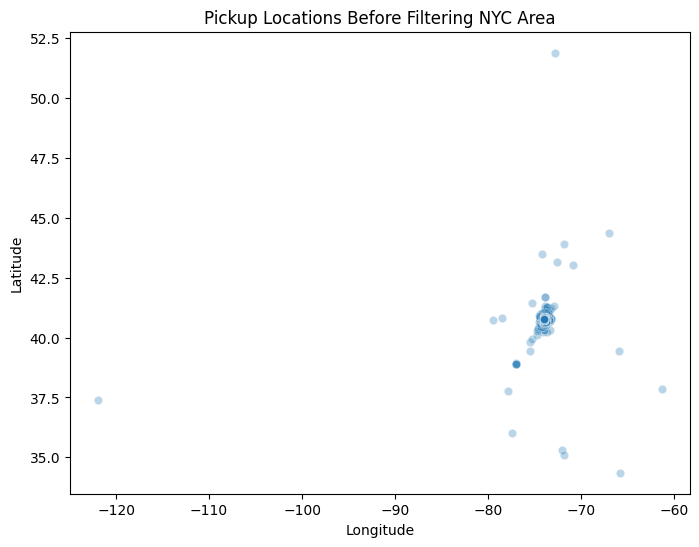

Number of trips completely outside NYC: 3390 out of 1000000
Number of trips after filtering: 996610


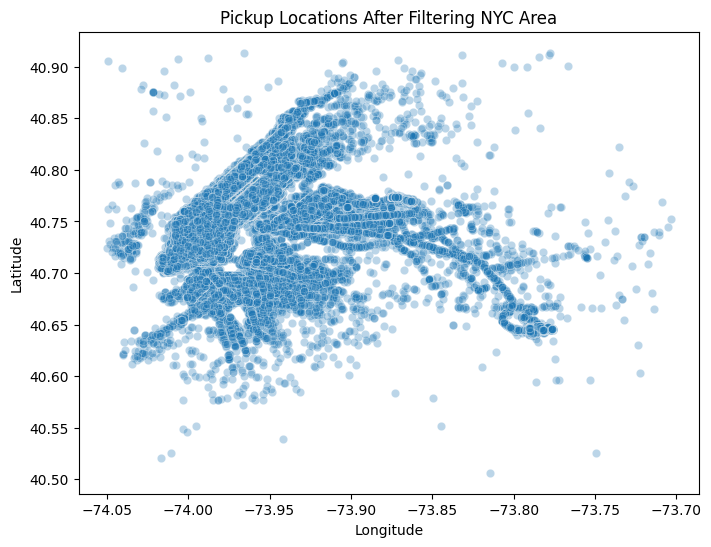

In [ ]:
# Descriptive statistics for coordinates
print(df[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].describe())

# Scatter plot of pickup locations before filtering
plt.figure(figsize=(8, 6))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=df, alpha=0.3)
plt.title("Pickup Locations Before Filtering NYC Area")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Define reasonable NYC boundaries
lat_min, lat_max = 40.5, 40.92
lon_min, lon_max = -74.05, -73.7

# Filter trips within NYC boundaries
mask_nyc = (
    (df['pickup_latitude'].between(lat_min, lat_max)) &
    (df['pickup_longitude'].between(lon_min, lon_max)) &
    (df['dropoff_latitude'].between(lat_min, lat_max)) &
    (df['dropoff_longitude'].between(lon_min, lon_max))
)

# Count trips outside NYC boundaries
num_outside = (~mask_nyc).sum()
print(f"Number of trips completely outside NYC: {num_outside} out of {len(df)}")

# Keep only trips within NYC
df = df[mask_nyc].copy()
print(f"Number of trips after filtering: {len(df)}")

# Scatter plot of pickup locations after filtering
plt.figure(figsize=(8, 6))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=df, alpha=0.3)
plt.title("Pickup Locations After Filtering NYC Area")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


#  NYC Trips Filtering

We noticed that many trips have coordinates outside the NYC area.  
We will define reasonable upper and lower thresholds for latitude and longitude to remove trips that fall outside these bounds.  

After filtering, we will report the number of trips that were completely outside the NYC range.


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Traffic Analysis by Time

Now we want to understand traffic patterns based on hour of the day or day of the week.  

This will help us decide on future feature engineering, such as `rush_hour`, `weekday`, `month`, etc.


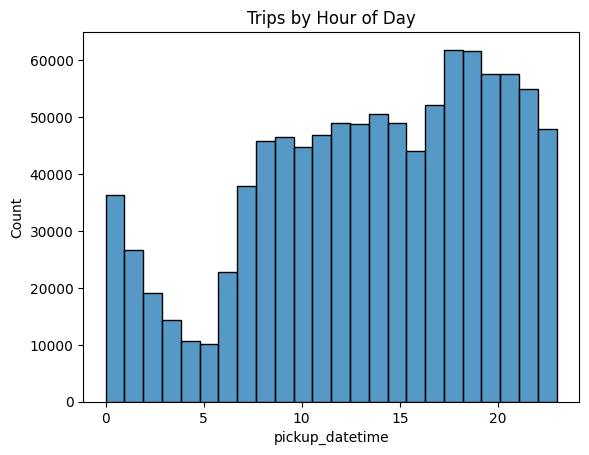

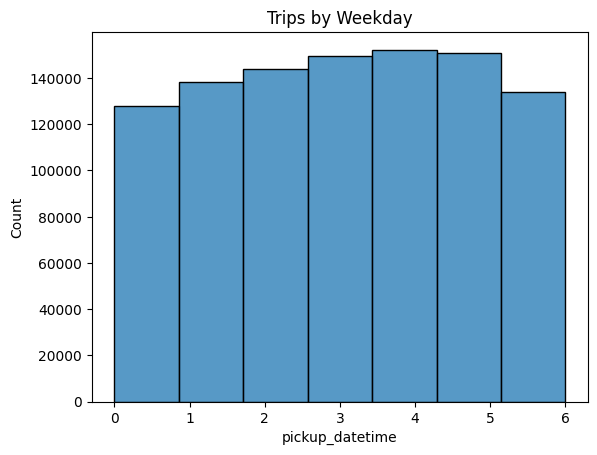

In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
sns.histplot(df['pickup_datetime'].dt.hour, bins=24)
plt.title("Trips by Hour of Day")
plt.show()

sns.histplot(df['pickup_datetime'].dt.weekday, bins=7)
plt.title("Trips by Weekday")
plt.show()


# We noticed the following
Trips are busiest between 17:00–21:00 (evening rush) with a smaller peak at 8:00–10:00 (morning rush).









--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


# Now, we want to explore the relationships between the features and our target value.

 Correlation between numerical features and `trip_duration`.

trip_duration        1.000000
trip_duration_min    1.000000
pickup_longitude     0.060528
dropoff_longitude    0.046316
vendor_id            0.028596
passenger_count      0.012126
dropoff_latitude    -0.031123
pickup_latitude     -0.040231
Name: trip_duration_min, dtype: float64


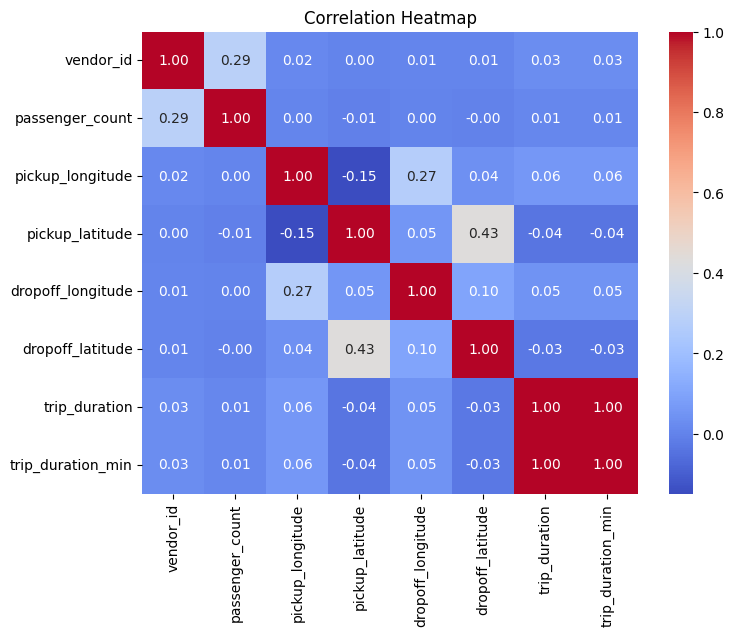

In [ ]:
# Select only numerical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Compute correlation matrix
corr = df[numeric_cols].corr()

# Examine correlation of trip_duration_min with other numerical features
print(corr['trip_duration_min'].sort_values(ascending=False))

# Heatmap of correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()







# We noticed that correlations are not very strong yet

because the data features are still not fully representative.  
We need to create **new features** that better capture domain-specific relationships and have stronger connections to the target variable.


Let's explore the relationship between **passenger count** and **trip duration**, as we suspect that trips with more passengers might take longer.


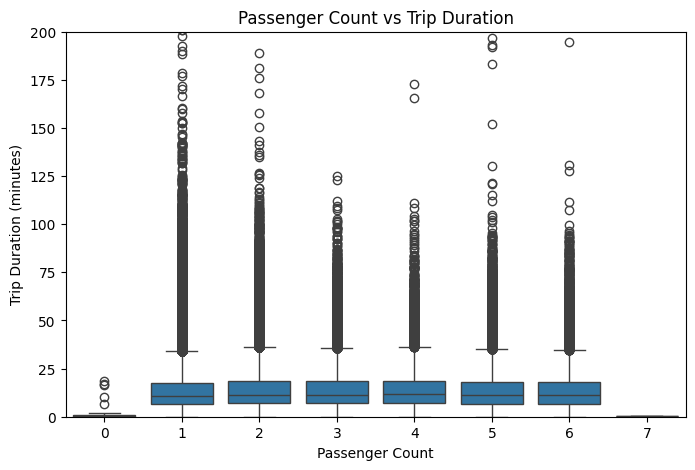

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='passenger_count', y='trip_duration_min')
plt.ylim(0, 200)  # Limit y-axis to reduce the effect of extreme outliers
plt.title("Passenger Count vs Trip Duration")
plt.xlabel("Passenger Count")
plt.ylabel("Trip Duration (minutes)")
plt.show()


From this analysis, we can conclude that the number of passengers does not significantly affect the trip duration.


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------








Next, let's examine how `vendor_id` and `store_and_fwd_flag` relate to the trip duration.


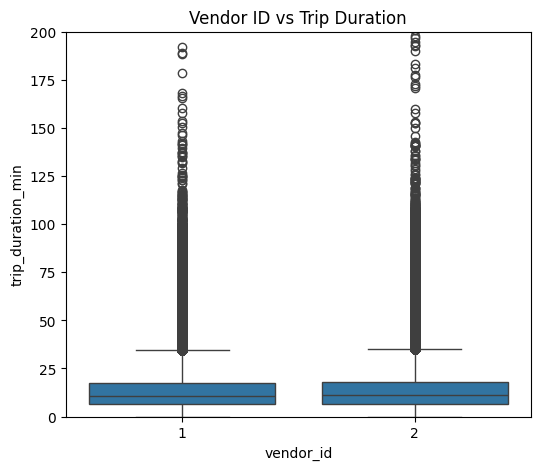

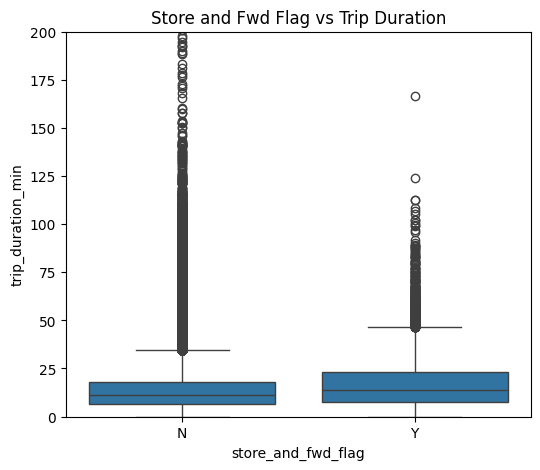

In [ ]:
# Vendor
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x='vendor_id', y='trip_duration_min')
plt.ylim(0, 200)
plt.title("Vendor ID vs Trip Duration")
plt.show()

# Store and Forward
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x='store_and_fwd_flag', y='trip_duration_min')
plt.ylim(0, 200)
plt.title("Store and Fwd Flag vs Trip Duration")
plt.show()


We find that `vendor_id` does not have a significant effect on trip duration.  
However, `store_and_fwd_flag` seems to have some impact: trips where there was a connection issue (data stored first and sent later) tend to have slightly longer durations than trips sent immediately (`store_and_fwd_flag` = N).


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Feature Engineering

Now that we have a general idea of our data, we notice it is not expressive enough on its own.  
However, we can create new features that are more meaningful and directly related to our target, such as:

- **Distances:** Haversine, Manhattan  
- **Directions & speed:** Bearing, speed_kmh  
- **Datetime-based features:** Extracting hour, weekday, weekend, etc., since the time of day may be more important than the date itself  

All these operations will be done using the `features` module, where all functions are organized.  

Next, we move to the `02_feature_engineering` notebook and save the processed file.



--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# New Features Make Sense

After adding the new features and inspecting some of them, we can see they are more meaningful.  
Longer distances result in higher trip durations, and for trips with similar distances, higher speeds lead to shorter durations.


### Exploring New Features vs Target

Now we start examining the relationships between the newly created features and the target variable.  
After generating the features and applying one-hot encoding on categorical features, we removed approximately 13% of the data that considered outliers.


In [ ]:
path = r"G:/ML mostafa saad/slides/my work/13 Project 1 - Regression - Trip Duration Prediction/data/processed/train_processed_filtered.csv"
df_processed = pd.read_csv(path)

df_processed.head()
print(df_processed.shape)
print(df_processed.info())
df_processed.describe()

print(df_processed.columns.tolist())


(974935, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974935 entries, 0 to 974934
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   passenger_count       974935 non-null  int64  
 1   pickup_longitude      974935 non-null  float64
 2   pickup_latitude       974935 non-null  float64
 3   dropoff_longitude     974935 non-null  float64
 4   dropoff_latitude      974935 non-null  float64
 5   trip_duration         974935 non-null  int64  
 6   haversine_km          974935 non-null  float64
 7   manhattan_km          974935 non-null  float64
 8   bearing_deg           974935 non-null  float64
 9   speed_kmh             974935 non-null  float64
 10  hour                  974935 non-null  int64  
 11  is_weekend            974935 non-null  int64  
 12  is_rush_hour          974935 non-null  int64  
 13  log_trip_duration     974935 non-null  float64
 14  vendor_id_1           974935 non-null  

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Analyzing Relationships Between New Features and Target

Let's now examine how the newly created features relate to our target variable.


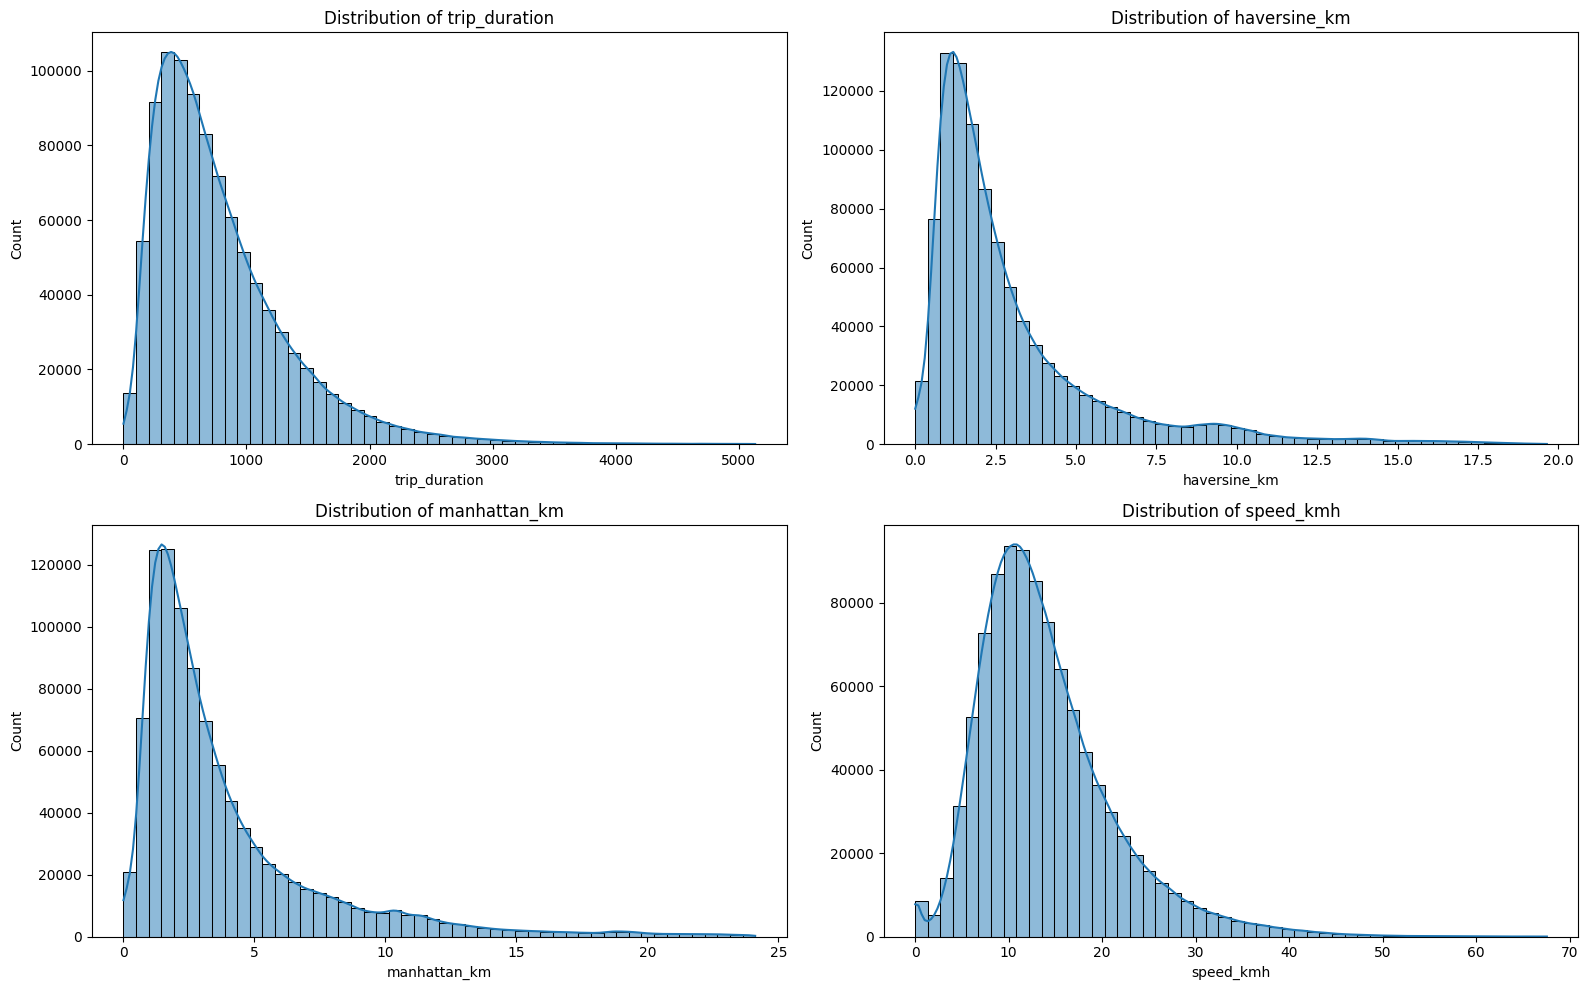

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = ['trip_duration', 'haversine_km', 'manhattan_km', 'speed_kmh']

plt.figure(figsize=(16,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_processed[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


In [ ]:
print(df_processed[df_processed['speed_kmh'] < 5][['trip_duration', 'haversine_km', 'speed_kmh']].head(10))

print(df_processed[df_processed['speed_kmh'] > 30][['trip_duration', 'haversine_km', 'speed_kmh']].head(10))

print(df_processed['speed_kmh'].describe())

     trip_duration  haversine_km  speed_kmh
23            1618      0.490001   1.090237
24             696      0.789954   4.085968
33            1134      1.475405   4.683824
58              26      0.014515   2.009802
62            1212      0.000000   0.000000
93            2102      2.616572   4.481283
125           1065      1.374783   4.647155
140           1229      1.457771   4.270118
161            654      0.724880   3.990168
162           1257      0.039915   0.114314
     trip_duration  haversine_km  speed_kmh
27             787      7.594700  34.740687
44             348      2.933929  30.350987
54             354      3.237447  32.923188
67             415      3.656243  31.716805
119            475      4.566709  34.610851
120            465      5.345532  41.384765
122            812      9.175324  40.678775
151            883     11.899912  48.516061
187            982     12.150920  44.545126
219           1322     11.597628  31.582044
count    974935.000000
mean     

### Data Distribution and Logic Check

The new features seem reasonable, and the overall data distribution looks relatively sound.


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Quick Look at Some Categorical Variables

Let's take a brief look at the distribution of a few categorical features, for example:

- `passenger_count`
- `hour`
- `is_weekend`
- `is_rush_hour`


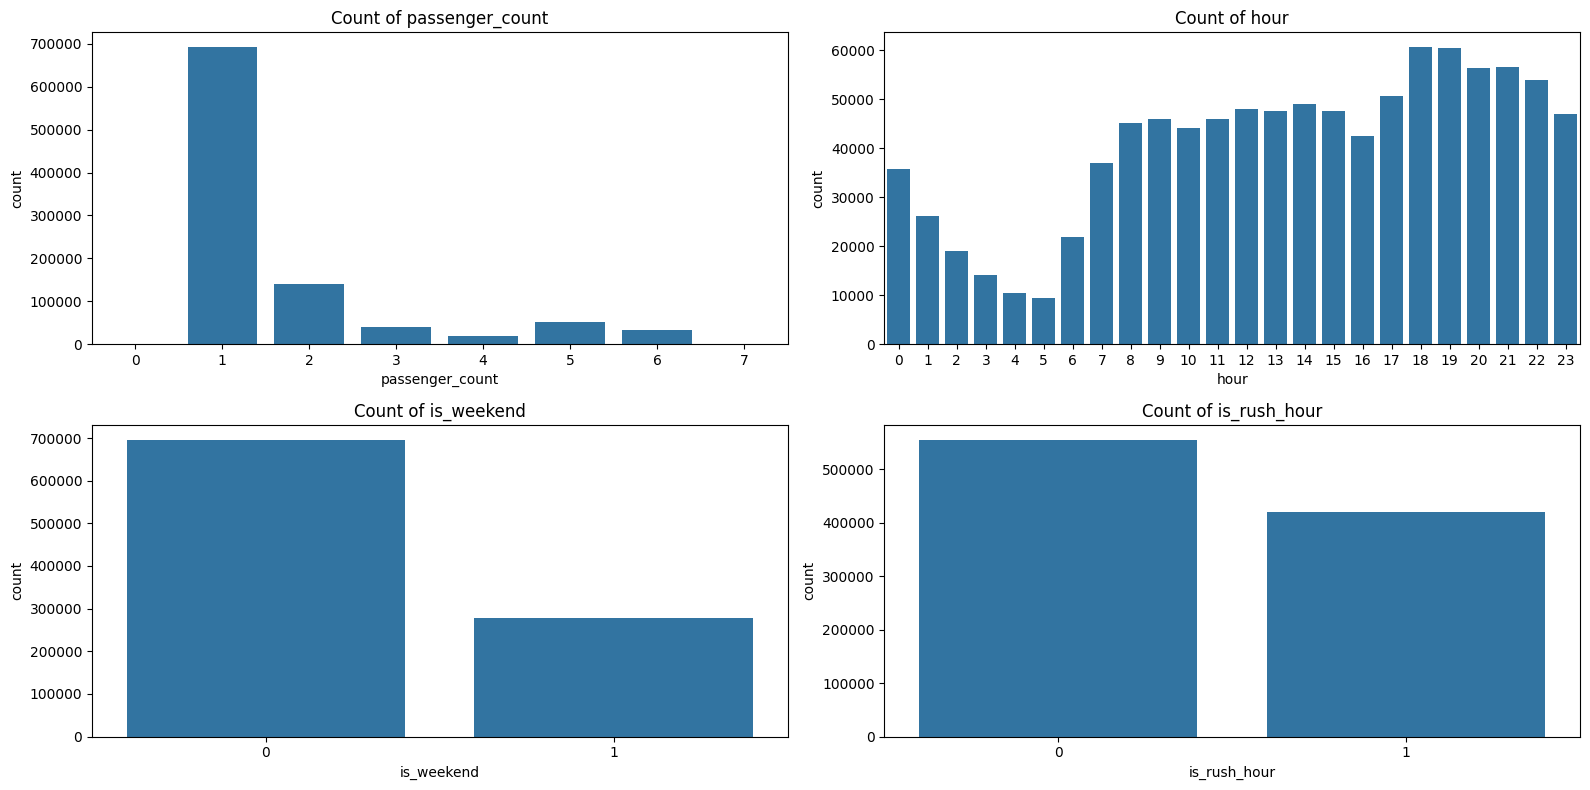

In [ ]:
cat_cols = ['passenger_count', 'hour', 'is_weekend', 'is_rush_hour']

plt.figure(figsize=(16,8))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, data=df_processed)
    plt.title(f'Count of {col}')
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Exploring Relationships Between Variables

Let's examine some relationships between key features, for example:

- Trip Duration vs Distance vs Speed


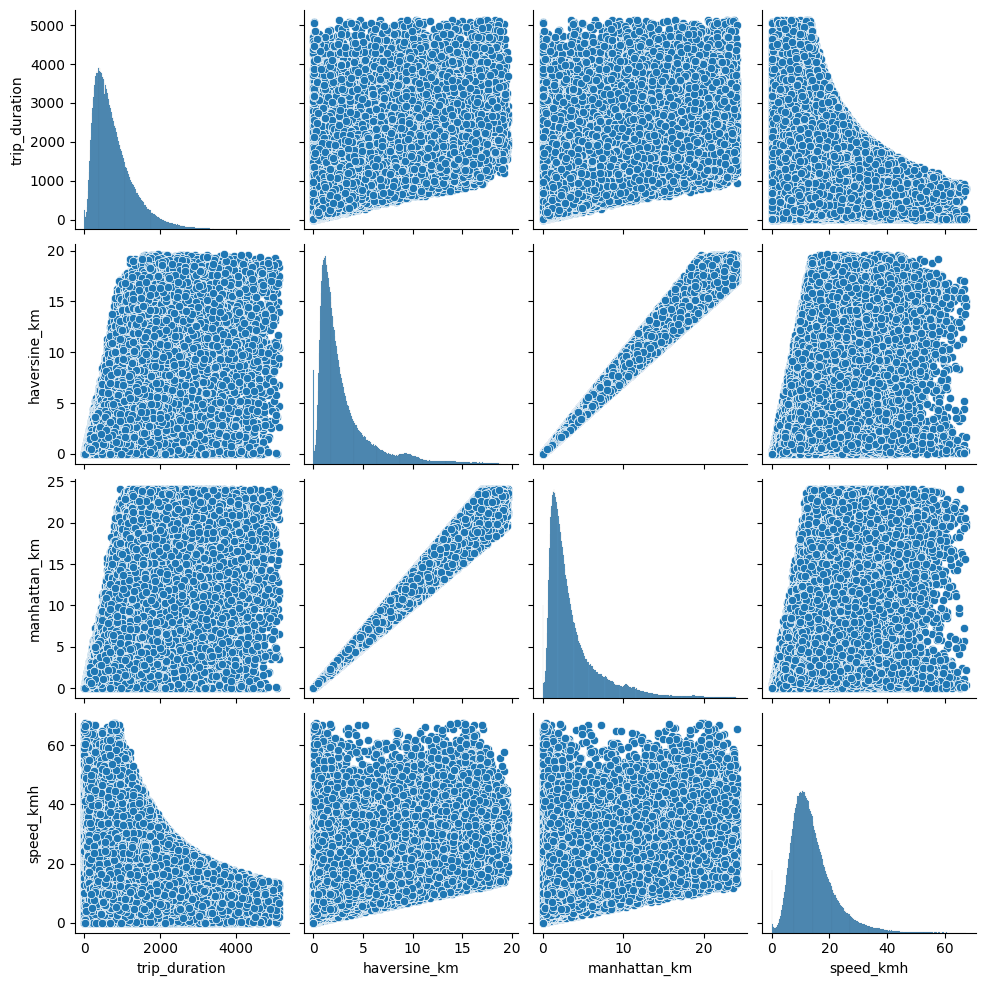

In [ ]:
sns.pairplot(df_processed[['trip_duration', 'haversine_km', 'manhattan_km', 'speed_kmh']])
plt.show()


### Observations on Feature Relationships

We can see that the relationships make sense:

- Speed is inversely related to trip duration (higher speed → shorter duration).  
- Distance is directly related to trip duration (longer distance → longer duration).
- And so on with all features


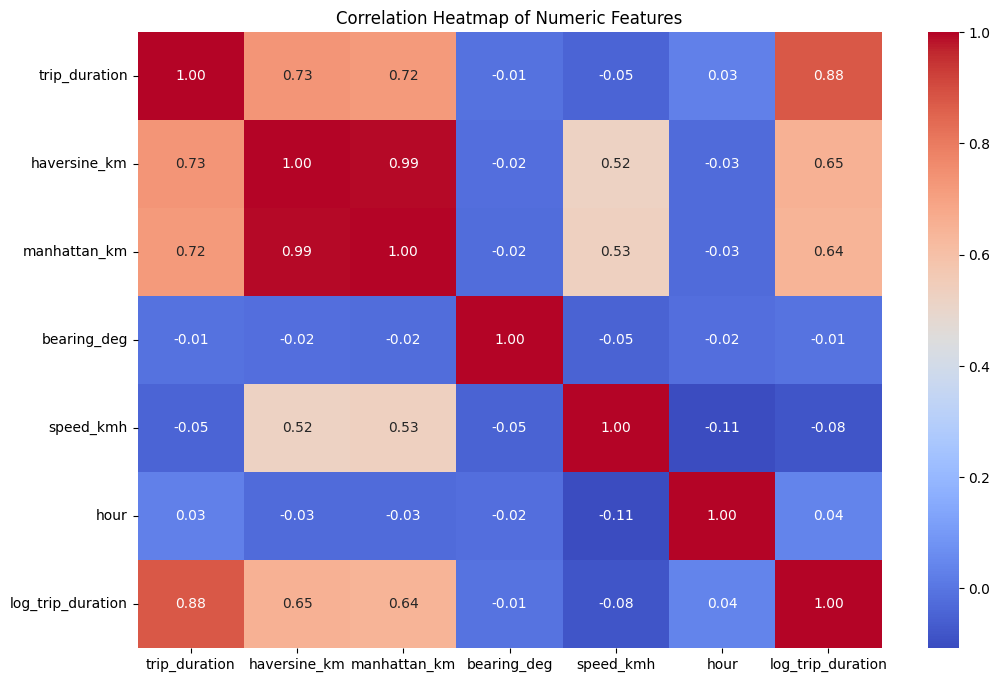

In [ ]:
plt.figure(figsize=(12,8))
numeric_cols = ['trip_duration', 'haversine_km', 'manhattan_km', 'bearing_deg', 'speed_kmh', 'hour', 'log_trip_duration']
corr_matrix = df_processed[numeric_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


# Conclusion of The EDA

At this point, we have understood the data, cleaned it, and engineered meaningful features.  
We are now ready to move on to the modeling phase.
